In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf

In [2]:
def generateChirp(start, end, sr, dur, samples = None):
    '''
    Generates a chirp signal

    Parameters:
    start (float): start frequency of the chirp
    end (float): end frequency of the chirp
    sr (num): sampling rate
    dur (num):  time duration of tone
    '''
    if samples is None:
        samples = int(sr * dur)
    time = np.linspace(0, dur, samples, False)

    linear_chirp = librosa.chirp(fmin=start, fmax=end, sr = sr, length = samples, duration=dur, linear=True)  
    
    return linear_chirp


In [3]:
def signal_info(signal, sample_rate):
    
    duration = len(signal)/ sample_rate
    n_samples = int(duration * sample_rate)
    #time = np.arange(0, n_samples) / sample_rate

    print("Sampling Rate:", sample_rate)
    print("Signal time duration: ", duration)
    print("Number of samples: ", n_samples)

In [4]:
def plot_spectogram(signal, sr, n_fft = 128, title = "Spectrogram", hop_length = None, win_length = None, ax = None):
    '''
    Parameters:
    signal (np.array): the signal
    n_fft (num): length of the windowed signal
    '''
    if hop_length is None:
        hop_length = int(n_fft / 4)
    
    stft = librosa.stft(y=signal, n_fft = n_fft, hop_length = hop_length, win_length = win_length)
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    
    if hop_length is None:
        hop_length = int(n_fft / 4)  # You can adjust the hop length calculation as needed
    frame_times = librosa.frames_to_time(np.arange(spectrogram.shape[1]), sr=sr, hop_length=hop_length)

    #plt.figure(figsize=(10, 6))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='linear',x_coords=frame_times, ax=ax)
    #print(sr)
    #print(frame_times[len(frame_times)-1])
    
    #plt.ylim(17000,20000)
    
    #plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)

In [5]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

In [6]:
'''# generating chirp 
sampling_rate = 48000
duration = 0.01075
chirp = generateChirp(18000,20000, sampling_rate, duration, samples=512)

repeated_chirp = np.tile(chirp, 10)
sf.write('18-20kHz_chirp_rep_python.wav', repeated_chirp, sampling_rate)
sf.write('18-20kHz_chirp_10.75ms_python.wav', chirp, sampling_rate)'''


"# generating chirp \nsampling_rate = 48000\nduration = 0.01075\nchirp = generateChirp(18000,20000, sampling_rate, duration, samples=512)\n\nrepeated_chirp = np.tile(chirp, 10)\nsf.write('18-20kHz_chirp_rep_python.wav', repeated_chirp, sampling_rate)\nsf.write('18-20kHz_chirp_10.75ms_python.wav', chirp, sampling_rate)"

In [7]:
signal, sample_rate =librosa.load("/Users/Eshita/Desktop/Stuff/FMCW/ToneExperiment/Chirp/Chirp Data/Chirp Transmitted/18-20kHz_chirp_rep_python.wav", sr = 48000)
chirp_rec, sample_rate = librosa.load("/Users/Eshita/Documents/rep op.mp3", sr = 48000)

print("Input signal:-")
signal_info(signal, sample_rate)
print("\nOutput signal:-")
signal_info(chirp_rec, sample_rate)

Input signal:-
Sampling Rate: 48000
Signal time duration:  0.10666666666666667
Number of samples:  5120

Output signal:-
Sampling Rate: 48000
Signal time duration:  5.098270833333333
Number of samples:  244717


Text(0, 0.5, 'Amplitude')

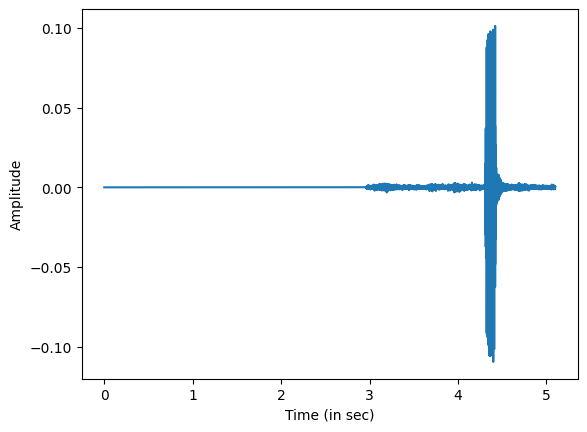

In [8]:
# Time vs Amplitude plot
plt.plot([i/sample_rate for i in range(len(chirp_rec))], chirp_rec)
plt.xlabel("Time (in sec)")
plt.ylabel("Amplitude")

In [9]:
F_in,A_in = compute_fft(signal, sample_rate)
F_out,A_out = compute_fft(chirp_rec, sample_rate)

print("Maximum frequency in input signal: ", F_in[np.argmax(A_in)])
print("Maximum frequency in output signal: ", F_out[np.argmax(A_out)])

Maximum frequency in input signal:  18375.0
Maximum frequency in output signal:  2249.586256778238


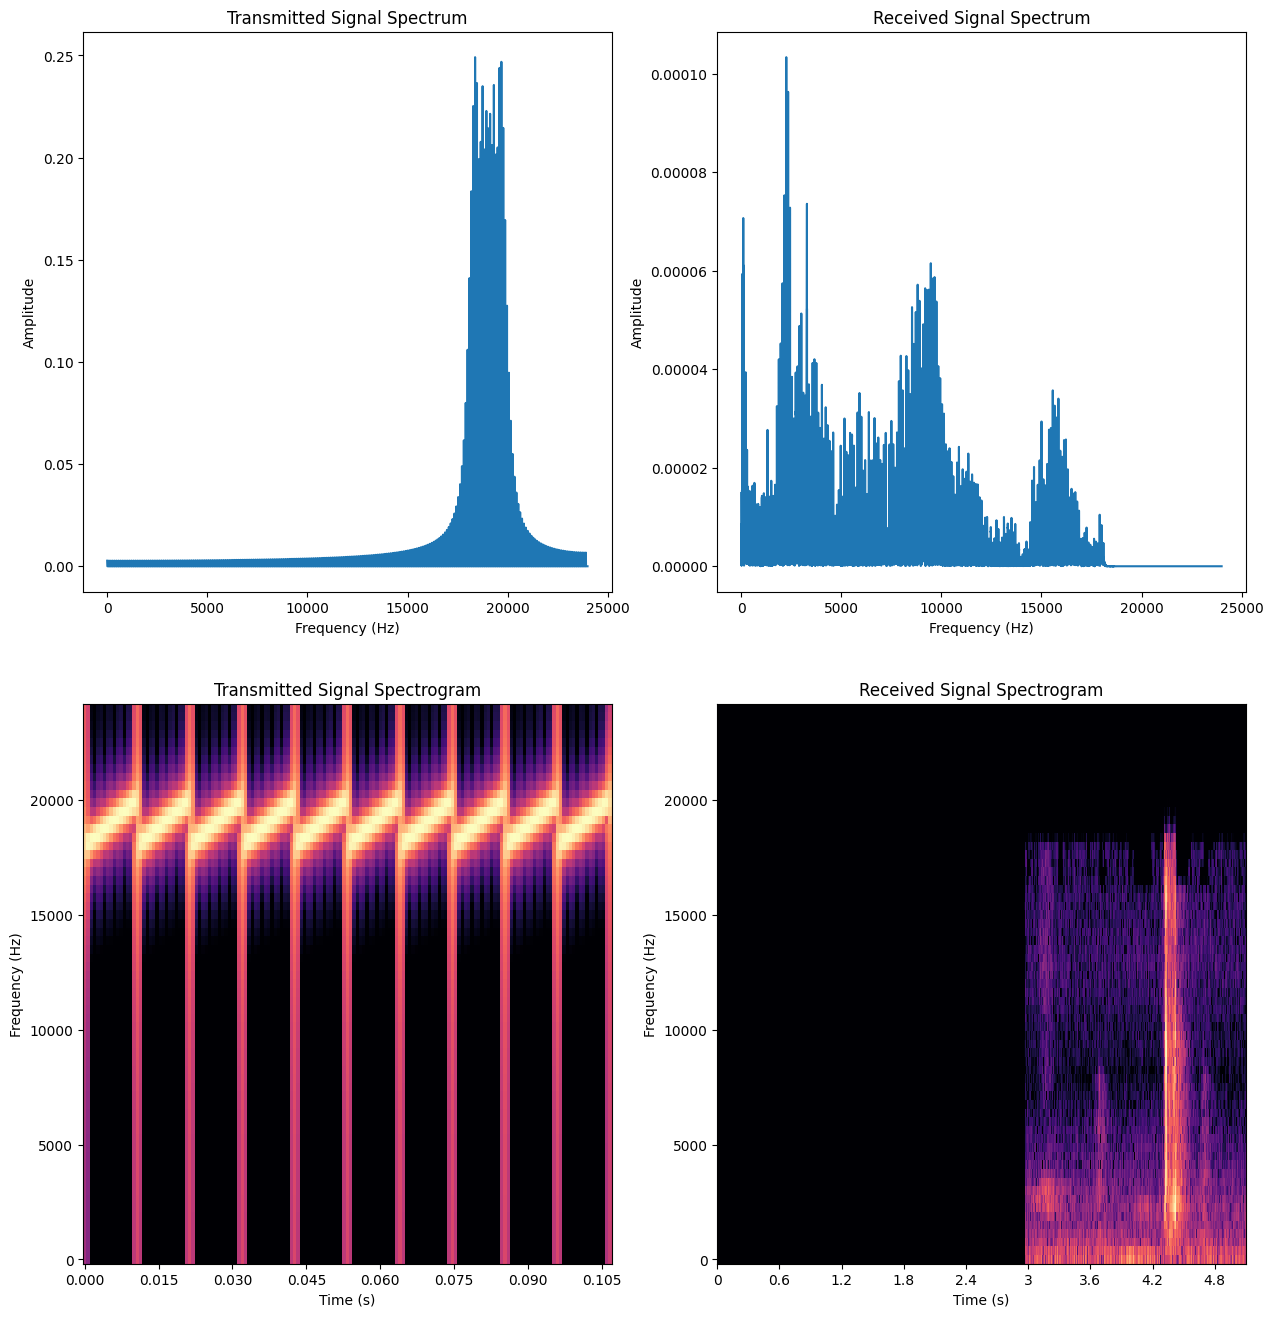

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(15, 16))

ax1.plot(F_in,A_in)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Transmitted Signal Spectrum')

ax2.plot(F_out,A_out)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Received Signal Spectrum')

plot_spectogram(signal,sample_rate, n_fft=128, title='Transmitted Signal Spectrogram', ax=ax3)
ax3.set_title('Transmitted Signal Spectrogram')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')

plot_spectogram(chirp_rec,sample_rate, n_fft=128, title='Received Signal Spectrogram', ax=ax4)

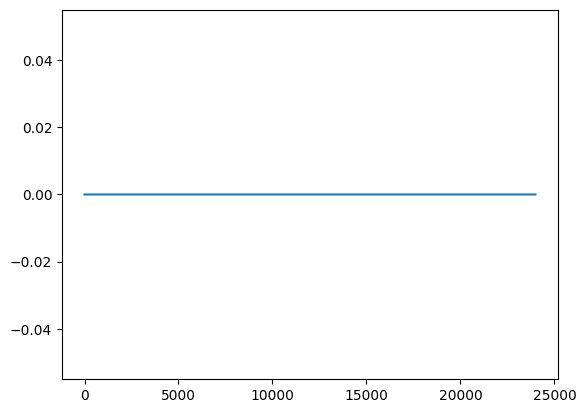

In [11]:
mixed = signal * chirp_rec[:5120]

F,A = compute_fft(mixed, sample_rate)
plt.plot(F,A)


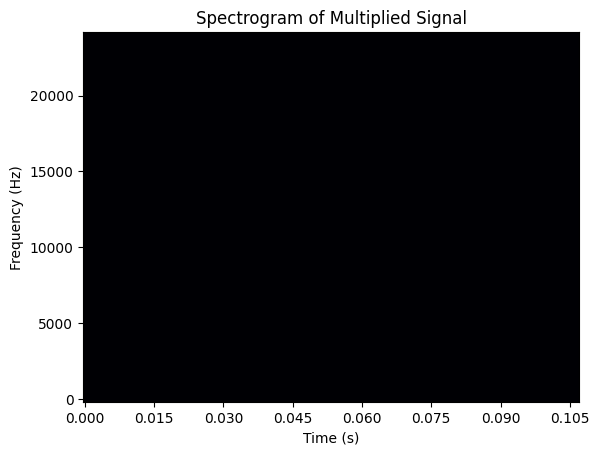

In [12]:
plot_spectogram(mixed, sample_rate, title="Spectrogram of Multiplied Signal")